In [2]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import db
import pasttrec_ctrl as ptc
import json
import baseline_calib
from my_utils import *
import tdc_daq as td
import matplotlib.pyplot as plt
import time

from my_utils import *
data_dir = make_data_dir()

Welcome to JupyROOT 6.14/04


['0010', '0007']


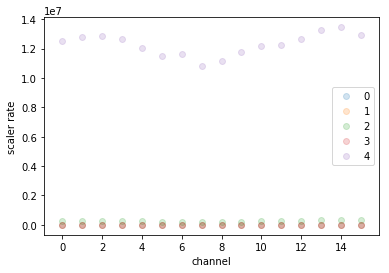

25 boards to activate, sequence of activation, boards list: 
['0010', '0011', '0009', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0007', '0002', '0004', '0027', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0006', '0028', '0008', '0005']


In [3]:
#db.board_list()
# measure_board_list = ['0021', '0014', '0003', '0018', '0022', '0026', '0025', '0027', '0002', '0007', '0004'] #layer2
# measure_board_list = ['0023', '0030', '0029', '0020', '0017', '0016', '0015', '0011', '0010', '0009'] # layer 3
#measure_board_list = ['0021', '0014', '0003', '0018', '0022', '0026', '0025', '0027', '0002', '0007', '0004', '0023', '0030', '0029', '0020', '0017', '0016', '0015', '0011', '0010', '0009']
measure_board_list = ['0010','0007']
print(measure_board_list)
name = "0010"
channel_to_analyse = 5
# good reference board longer wires  "0022", 0004, !! 0021!! (shortest wires)
# not working boards: 0025, 
# no dependence 0027, 0002
# step at 6 boards then constant 003
trend_scaler_list = []
for i in range(0,5):
    time.sleep(1)
    db.unset_standby_board(name)
    ptc.init_board_by_name(name,10,i,15)
    scaler_list = []
    #ptc.reset_board_by_name("0017")
    #ptc.init_active_boards()
    scaler_list = td.scaler_rate_of_board(name,0.2)
    trend_scaler_list += [scaler_list]
    plt.scatter(range(0,16),scaler_list,alpha=0.2,label = "{:d}".format(i))
    plt.legend()
    plt.xlabel("channel")
    plt.ylabel("scaler rate")
plt.show()

## define sequence of boards to activate in scan
next_fpc_difference = []
## generate alternating  +,- list of numbers 
for i in range(0,40):
    next_fpc_difference += [ i ]
    next_fpc_difference += [ -1*i ]
    
fpca = db.get_fpca_of_board(name)
fpcd = db.get_fpcd_of_board(name)
boards_scan_list = []
boards_scan_list += [ name ]
for chamber in range(0,6):
  nextchamber = db.get_chamber_of_board(name)+next_fpc_difference[chamber]
  for layer in range(0,6):
    nextlayer = db.get_layer_of_board(name)+next_fpc_difference[layer]
    for nplus in next_fpc_difference:
        nextfpca = fpca+nplus
        next_board = db.find_board_by_fpc(nextfpca,nextlayer,nextchamber)
        if next_board != 0 and next_board not in boards_scan_list:
            boards_scan_list += [ next_board ]

print( str(len(boards_scan_list)) + " boards to activate, sequence of activation, boards list: ")
print(boards_scan_list)

# db.dump_db_to_root("ee.root")    
# for my_board in db.nostandby_board_list():
#     print(my_board)

In [ ]:
## scan threshold of an single board as function of peaking time, gain, number of other boards switched on

import ROOT

# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)


#for my_board in db.board_list():
#  db.unset_standby_board(my_board) #name = "0029" #PASSTEC board id (inside )

c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
ROOT.gStyle.SetOptFit(1)
n_wires = 162
mg = ROOT.TMultiGraph()
mg2 = ROOT.TMultiGraph()
gr = [1, 2, 3, 4]
gr2 = [1, 2, 3, 4]
dependency_list = []

index_l = 0
#for p in [1,2,4]:  
for measureborad in measure_board_list: 
 for my_board in db.board_list():
            db.set_standby_board(my_board)
 for p in range(0,len(boards_scan_list)): 
    for my_board in db.board_list():
        if my_board == boards_scan_list[p]:
            db.unset_standby_board(my_board)
#         else:
#             db.set_standby_board(my_board)
        
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
    print("board switched on: ", boards_scan_list[p])
     # vary gain:
#     print("gain: ", p)
#     ptc.init_board_by_name(name,10,p,15)  # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):
    print("number of boards switched on: ", p)
    ptc.init_board_by_name(name,10,2,15)  # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):    
    #time.sleep(60)
    dependency_list += [ p ]
    
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)
    calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]

    #scaler_list = []
    #scaler_list = td.scaler_rate_of_board(name,0.2)
    root_name = "/workdir/noise_" + measureborad + "_scan0" + str(p) + ".root"
    print(root_name)
    db.dump_db_to_root_board(root_name,name)


board switched on:  0021
number of boards switched on:  0
/workdir/noise_0021_scan00.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0014
number of boards switched on:  1
/workdir/noise_0021_scan01.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0003
number of boards switched on:  2
/workdir/noise_0021_scan02.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0018
number of boards switched on:  3
/workdir/noise_0021_scan03.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0022
number of boards switched on:  4
/workdir/noise_0021_scan04.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0026
number of boards switched on:  5
/workdir/noise_0021_scan05.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0025
number of boards switched on:  6
/workdir/noise_0021_scan06.root
scanning keys of board: 0021

/workdir/noise_0003_scan05.root
scanning keys of board: 0021
dumping data of board: 0021
board switched on:  0025
number of boards switched on:  6


In [ ]:
import root_fit as fit

for measureborad in measure_board_list: 


    color_contrast_array = [1,632,600,417,800,616,401,880,807,633,634,626,797,617,618,622]
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    ROOT.gStyle.SetOptFit(1)
    n_wires = 162
    mg = ROOT.TMultiGraph()
    mg2 = ROOT.TMultiGraph()
    mgDep = ROOT.TMultiGraph()
    legend = ROOT.TLegend(0.1,0.9,0.3,0.99);
    gr = [1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6]
    gr2 = [1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6,1, 2, 3, 4, 5, 6]
    grDep = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
    dependency_list = []
    c = ROOT.TCanvas("c","The Canvas Title",640,480); c.cd();
    index_l = -1
    # for p in [1,2,4]:   # PASTTREC gain scan
    #for p in [1,2,4]:   # PASTTREC peakingtime scan
    gr3 = ROOT.TGraphErrors(); 
    noise_by_dependency_list = []

    for index_channel in range(0,16): 
        grDep[index_channel] = ROOT.TGraphErrors(); 
        grDep[index_channel].SetMarkerStyle(3+index_channel);
        grDep[index_channel].SetMarkerColor(color_contrast_array[index_channel]); 
        grDep[index_channel].SetLineColor(color_contrast_array[index_channel]);   
    for p in range(0,22): 
        cscan = ROOT.TCanvas("cscan" + str(p),"The Canvas Title",640,480); cscan.cd();
        dependency_list += [ p ]
        root_name = "/workdir/noise_" + measureborad + "_scan0" + str(p) + ".root"
        print(root_name)
        f = ROOT.TFile(root_name)
        dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
        index_l += 1
        gr[index_l] = ROOT.TGraphErrors(); 
    #     gr[index_l].SetMarkerStyle(3+index_l); gr[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr[index_l].SetLineStyle(2); gr[index_l].SetLineColor(color_contrast_array[index_l]);
        gr2[index_l] = ROOT.TGraphErrors(); gr2[index_l].SetMarkerStyle(3+index_l);

    #     gr2[index_l].SetMarkerStyle(3+index_l); gr2[index_l].SetMarkerColor(color_contrast_array[index_l]); 
    #     gr2[index_l].SetLineStyle(2); gr2[index_l].SetLineColor(color_contrast_array[index_l]);    
        for l in range(1,4):
    #         index_l += 1
            stdev_list = []
            sigma_list = []
            mean_list = []    
            sigma_list_err = []
            mean_list_err = []  
            ipoint = 0
            for i in range(0,n_wires):
               c.cd() 
           #dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(120,-20,100)","chamber == 0 && layer == 3 && name == 0015 && board_chan == " + str(i) ,"colz")
               ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw >> raw_scan(150,-10,140)","name == " + name + " && chamber == 0 && layer == " + str(l) + " && wires == " + str(i) )  
               if (ndata > 0): 
                   cscan.cd()
                   raw_scan = f.Get("raw_scan")
                   results = fit.fit_scurve(raw_scan)
                   raw_scan.DrawCopy()
                   cscan.Draw()
                   cscan.SaveAs("noiseFit_lay" + str(l) +"_wire" + str(i) +"_scan" + str(p) +".png")
                   gr[index_l].SetPoint(ipoint, i, np.double(results[2]))
                   gr[index_l].SetPointError(ipoint, 0, np.double(results[3]) )
                   gr2[index_l].SetPoint(ipoint, i, np.double(results[4]))
                   gr2[index_l].SetPointError(ipoint, 0, np.double(results[5]) )
                   if(ipoint == channel_to_analyse ):
                       gr3.SetPoint(p, p, np.double(results[2]))
                       gr3.SetPointError(p, 0, np.double(results[3]) )
                       noise_by_dependency_list += [results[2]]
                   grDep[ipoint].SetPoint(p, p, np.double(results[2]))
                   grDep[ipoint].SetPointError(p, 0, np.double(results[3]) )  
                   ipoint += 1

        mg.Add(gr[index_l]); gr[index_l].SetTitle("layer " + str(l) ); 
        mg2.Add(gr2[index_l]); gr2[index_l].SetTitle("layer " + str(l) );  
    for index_channel in range(0,16):   
        mgDep.Add(grDep[index_channel]); grDep[index_channel].SetTitle("wire " + str(index_channel) );  

       #legend->SetHeader("The Legend Title","C"); // option "C" allows to center the header
        legend.AddEntry(gr[index_l],"gain " + str(p),"lp")

    plt.scatter(boards_scan_list[:len(noise_by_dependency_list)],noise_by_dependency_list,alpha=0.2,label = "{:d}".format(1))

    plt.xlabel("board active")
    plt.ylabel("noise threshold half max (DAC)")
    plt.show()



    c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
    mg.Draw("ap")
    mg.GetXaxis().SetTitle("wire number");
    mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
    legend.Draw()
    c1.Draw()
    c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
    c2.cd();
    mg2.Draw("ap")
    mg2.GetXaxis().SetTitle("wire number");
    mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
    legend.Draw()
    c2.Draw()

    c3 = ROOT.TCanvas("c3","The Canvas Title",640,480); c3.cd();
    gr3.Draw("a*p")
    gr3.GetXaxis().SetTitle("number of active boards");
    gr3.GetYaxis().SetTitle("noise threshold half max [2mV]");
    gr3.GetYaxis().SetRangeUser(0,12)
    c3.Draw()

    cDep = ROOT.TCanvas("cDep","The Canvas Title",640,480); cDep.cd();
    mgDep.Draw("ap")
    mgDep.GetXaxis().SetTitle("number of active boards");
    mgDep.GetYaxis().SetTitle("noise threshold half max [2mV]");
    mgDep.GetYaxis().SetRangeUser(0,12)
    mgDep.Draw()
    legend.Draw()
    cDep.Draw()
    
    c1.SaveAs("board" + measureborad + "_scan_mean.root")
    c2.SaveAs("board" + measureborad + "_scan_sigma.root")
    c3.SaveAs("board" + measureborad + "_noise_vs_no_active_boards.root")
    cDep.SaveAs("board" + measureborad + "_noise_vs_no_active_boards_allchan.root")    

In [ ]:
c3 = ROOT.TCanvas("c3","The Canvas Title",640,480); c3.cd();
gr3.Draw("a*p")
gr3.GetXaxis().SetTitle("number of active boards");
gr3.GetYaxis().SetTitle("noise threshold half max [2mV]");
gr3.GetYaxis().SetRangeUser(0,40)
gr3.Draw("a*p")
c3.Draw()

c1 = ROOT.TCanvas("c1","The Canvas Title",640,480); c1.cd();
mg.Draw("ap")
mg.GetXaxis().SetTitle("wire number");
mg.GetYaxis().SetTitle("noise threshold half max (DAC)");
mg.GetYaxis().SetRangeUser(4,6)
mg.Draw("ap")
legend.Draw()
c1.Draw()
c2 = ROOT.TCanvas("c2","The Canvas Title",640,480); c2.cd();
c2.cd();
mg2.Draw("ap")
mg2.GetXaxis().SetTitle("wire number");
mg2.GetYaxis().SetTitle("noise threshold sigma (DAC)");
mg2.GetYaxis().SetRangeUser(-1,2)
mg2.Draw("ap")
legend.Draw()
c2.Draw()

cDep = ROOT.TCanvas("cDep","The Canvas Title",640,480); cDep.cd();
mgDep.Draw("ap")
mgDep.GetXaxis().SetTitle("number of active boards");
mgDep.GetYaxis().SetTitle("noise threshold half max [2mV]");
mgDep.GetYaxis().SetRangeUser(0,12)
mgDep.Draw()
legend.Draw()
cDep.Draw()

c1.SaveAs("board" + name + "_scan_mean.root")
c2.SaveAs("board" + name + "_scan_sigma.root")
c3.SaveAs("board" + name + "_noise_vs_no_active_boards.root")